In [1]:
# 16/06/2020
# TASI.AI
# Raphael Mourad

# GARCH model: one issue of ARIMA models is that these autoregressive models 
# do not model a change in the variance over time.
# In the context of a time series in the financial domain, change in the variance would be 
# called increasing and decreasing volatility.
# Specifically, a GARCH models the variance at a time step as a function of 
# the residual errors from a mean process (e.g. a zero mean).

# Tutorials on GARCH:
# https://pyflux.readthedocs.io/en/latest/garch.html
# https://www.quantstart.com/articles/Generalised-Autoregressive-Conditional-Heteroskedasticity-GARCH-p-q-Models-for-Time-Series-Analysis/

# A very good tutorial explaining both ARIMA and GARCH!
# http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

# So GARCH predicts the variance of a time series, not the mean as ARIMA does!
# GARCH works by using as input the residuals (white noise or volatility) of a model such as ARIMA.

###### IMPORT LIBRARIES AND SET UP PARAMETERS

# Import libraries
import os
import pandas as pd
import numpy as np
import pyflux as pf
import seaborn
import matplotlib
import pmdarima
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima, ARIMA
from pandas_datareader import DataReader
from datetime import datetime
from matplotlib import pyplot
from scipy.stats import norm
from arch import arch_model

In [2]:
# Set up directory
dir="/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri"
os.chdir(dir)
print(os.getcwd())

/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri


In [3]:
# Parameters
symbol="AAPL" # Set up the symbol you want
kdays=30 # Number of days for forecasting

In [4]:
# Create folder for symbol
if(os.path.isdir("results/GARCH/")==False):
    os.mkdir("results/GARCH/", mode=0o777)
symbolFolder="results/GARCH/"+symbol
if(os.path.isdir(symbolFolder)==False):
    os.mkdir(symbolFolder, mode=0o777)

In [5]:
###### LOAD AND PREPROCESS DATA

# Import price
path="data/stockquotes/samples_L3_stockquotes_sample.csv.gz"
data_stockquotes = pd.read_csv(path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_stockquotes["quotedate"] = pd.to_datetime(data_stockquotes["quotedate"])
#print(data_stockquotes)
#print(np.unique(data_stockquotes["symbol"]))

In [6]:
# Choose the stock
data_stockquotes_sel=data_stockquotes[data_stockquotes["symbol"]==symbol]
data_stockquotes_sel=data_stockquotes_sel.sort_values('quotedate')
data_stockquotes_sel=data_stockquotes_sel.set_index('quotedate')
#print(data_stockquotes_sel)

In [7]:
# Check the absence of missing data 
NAcount=data_stockquotes.isnull().sum().sum()
print("Missing data=",NAcount)

Missing data= 0


In [8]:
# Extract close price
priceClose=data_stockquotes_sel["close"]
print(priceClose)

quotedate
2015-05-01    128.949997
2015-05-04    128.699997
2015-05-05    125.800003
2015-05-06    125.010002
2015-05-07    125.260002
                 ...    
2020-05-22    318.890000
2020-05-26    316.730000
2020-05-27    318.110000
2020-05-28    318.250000
2020-05-29    317.940000
Name: close, Length: 1278, dtype: float64


In [9]:
###### BUILD AND AUTOSELECT ARIMA MODEL

# Split train/test data
# Note to Rim and Quinn: train data will be used only to build the model, 
# and test data will be used only to assess forecasting accuracy of the model.
priceCloseTrain = priceClose[0:(len(priceClose)-kdays)]
priceCloseTest = priceClose[(len(priceClose)-kdays):len(priceClose)]
#print(priceCloseTrain)
#print(priceCloseTest[0:5])

In [10]:
# Build ARIMA model and finding automatically the best ARIMA model (function called auto_arima)
autoARIMA = auto_arima(priceCloseTrain, seasonal=False, trace=True,
                error_action='ignore', suppress_warnings=True, stepwise=True)
ARIMAbestparams=autoARIMA.order

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=6694.466, BIC=6725.237, Time=0.333 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6738.855, BIC=6749.112, Time=0.022 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=6689.255, BIC=6704.641, Time=0.066 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6693.335, BIC=6708.720, Time=0.096 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=6738.392, BIC=6743.520, Time=0.018 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=6690.681, BIC=6711.195, Time=0.112 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6690.775, BIC=6711.289, Time=0.129 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=6688.387, BIC=6714.030, Time=0.310 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=6656.338, BIC=6687.109, Time=0.652 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=6692.338, BIC=6717.981, Time=0.134 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercep

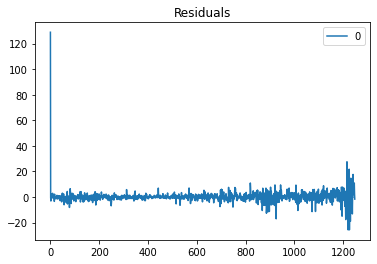

In [11]:
###### ANALYZE ARIMA RESIDUALS TO DETERMINE IF GARCH SHOULD BE USED

# Plot residual errors
plotResiduals=symbolFolder+"/plot_ARIMA_residuals_"+symbol+".pdf"
residualTrain=pd.DataFrame(autoARIMA.resid())
residualTrain.plot(title="Residuals")
pyplot.savefig(plotResiduals, bbox_inches='tight')
pyplot.show()

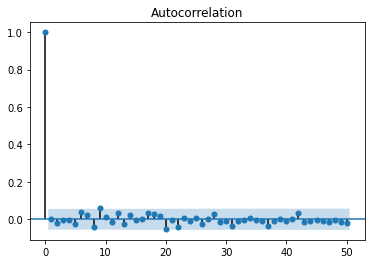

In [12]:
# Plot autocorrelation function (ACF). Here on ARIMA residuals.
plotACF=symbolFolder+"/plot_ACF_ARIMA_residuals_"+symbol+".pdf"
plot_acf(residualTrain,lags=50)
pyplot.savefig(plotACF, bbox_inches='tight')
pyplot.show()

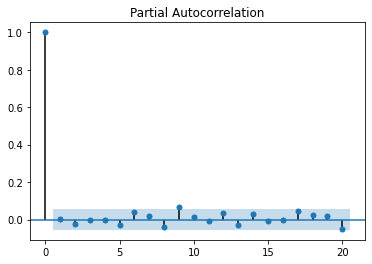

In [13]:
# Plot partial autocorrelations (PACF). Here on ARIMA residuals.
plotPACF=symbolFolder+"/plot_PACF_ARIMA_residuals_"+symbol+".pdf"
plot_pacf(residualTrain,lags=20)
pyplot.savefig(plotPACF, bbox_inches='tight')
pyplot.show()

In [14]:
###### BUILD GARCH MODEL
# A GARCH model should be built if autocorrelation on residuals was previously found. 

# Build GARCH model and finding automatically the best GARCH model 
squaredResidualTrain=residualTrain**2
squaredResidualTrain.ix=squaredResidualTrain.iloc # allows to fix a bug of pyflux package with pandas package!
pmax=4
qmax=6
aicModels = np.zeros( ((pmax-1)*(qmax-1), 3) )
k=0
for p in range(1, pmax):
    for q in range(1, qmax):
        GARCHmodel = pf.GARCH(squaredResidualTrain,p=p,q=q)
        aicModels[k,0]=p
        aicModels[k,1]=q
        aicModels[k,2]=GARCHmodel.fit().aic
        k=k+1

print("GARCH models and corresponding AICs:")
print(aicModels)
bestParams=aicModels[np.argmin(aicModels[:,2]),:]
print("\nBest GARCH parameters: p=" + str(int(bestParams[0])) + ", q=" + str(int(bestParams[1])))

GARCH models and corresponding AICs:
[[1.00000000e+00 1.00000000e+00 1.02976310e+04]
 [1.00000000e+00 2.00000000e+00 1.02794380e+04]
 [1.00000000e+00 3.00000000e+00 1.02744086e+04]
 [1.00000000e+00 4.00000000e+00 1.02716191e+04]
 [1.00000000e+00 5.00000000e+00 1.02680223e+04]
 [2.00000000e+00 1.00000000e+00 1.02794127e+04]
 [2.00000000e+00 2.00000000e+00 1.02812536e+04]
 [2.00000000e+00 3.00000000e+00 1.02762227e+04]
 [2.00000000e+00 4.00000000e+00 1.02734310e+04]
 [2.00000000e+00 5.00000000e+00 1.02698397e+04]
 [3.00000000e+00 1.00000000e+00 1.02700247e+04]
 [3.00000000e+00 2.00000000e+00 1.02720244e+04]
 [3.00000000e+00 3.00000000e+00 1.02560845e+04]
 [3.00000000e+00 4.00000000e+00 1.02531907e+04]
 [3.00000000e+00 5.00000000e+00 1.35752608e+04]]

Best GARCH parameters: p=3, q=4


In [15]:
# Best GARCH model
GARCHbestmodel = pf.GARCH(squaredResidualTrain,p=int(bestParams[0]),q=int(bestParams[1]))
print(GARCHbestmodel.fit().summary())

Hessian not invertible! Consider a different model specification.

GARCH(3,4)                                                                                                
======================================================= ==================================================
Dependent Variable: 0                                   Method: MLE                                       
Start Date: 4                                           Log Likelihood: -5117.5953                        
End Date: 1247                                          AIC: 10253.19065728908                            
Number of observations: 1244                            BIC: 10299.325442748772                           
Latent Variable                          Estimate  
======================================== ==========
Vol Constant                             1.2038    
q(1)                                     0.0216    
q(2)                                     0.0809    
q(3)                           

In [16]:
###### FORECAST PRICE VARIANCE (VOLATILITY) USING GARCH MODEL

# Plot volatility of train data
volatilityTrain=GARCHbestmodel.fit()
volatilityTrain.scores=pd.DataFrame(volatilityTrain.scores,columns=['Absolute Demeaned Values'],
                                     index=priceCloseTrain.index.values[int(bestParams[1]):len(priceCloseTrain.index.values)])
volatilityTrain.signal=pd.DataFrame(volatilityTrain.signal,columns=['Volatility'],
                                     index=priceCloseTrain.index.values[int(bestParams[1]):len(priceCloseTrain.index.values)])

In [28]:
# Forecast conditional volatility
volatilityForecast=GARCHbestmodel.predict(h=kdays, intervals=True)
volatilityForecastMean=volatilityForecast["0"]
print(volatilityForecast[1:5])

                 0  1% Prediction Interval  5% Prediction Interval  \
1249  52061.037503            52005.462705            52005.468355   
1250  50005.157073            49731.424480            49731.596481   
1251  51238.567117            50931.495174            50931.691461   
1252  48612.293894            48279.766696            48280.025272   

      95% Prediction Interval  99% Prediction Interval  
1249             52034.741663             52982.474657  
1250             50002.418084             56697.126152  
1251             51319.826442             58258.499191  
1252             49134.248223             56316.753884  


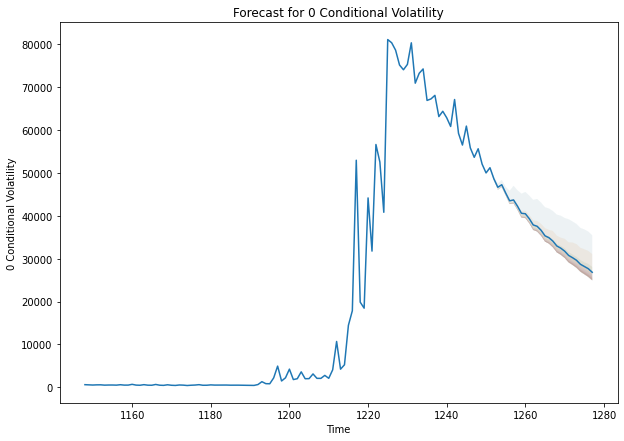

In [18]:
# Plot forecasted conditional volatility (simple plot)
GARCHbestmodel.plot_predict(h=kdays, past_values=100, intervals=True)

81132.39218561118
81132.39218561118


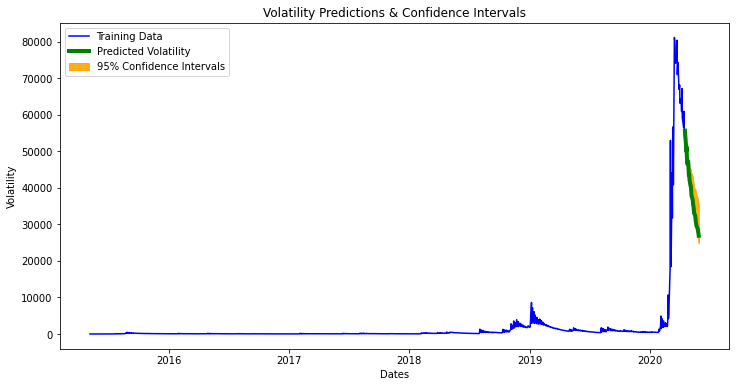

In [19]:
# Plot forecasted conditional volatility
plotVolatilityForecast=symbolFolder+"/plot_GARCH_volatilityForecasting_"+symbol+"_"+str(kdays)+"days.pdf"
fig, axes = pyplot.subplots(1, 1, figsize=(12, 6))

maxY=np.max(volatilityTrain.signal[(len(priceCloseTrain)-300):len(priceCloseTrain)])[0]
#print(maxY)
#print(np.max(volatilityTrain.signal)[0])

axes.plot(volatilityTrain.signal, color='blue', label="Training Data")
axes.plot(priceCloseTest.index, volatilityForecast["0"], color='green', linewidth=4, label='Predicted Volatility')
axes.set_title('Volatility Predictions & Confidence Intervals')
axes.set_xlabel('Dates')
axes.set_ylabel('Volatility')
#pyplot.ylim((0,maxY*10))

conf_int = np.asarray(volatilityForecast[["5% Prediction Interval","95% Prediction Interval"]])
axes.fill_between(priceCloseTest.index, conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange', label="95% Confidence Intervals")
axes.legend()
pyplot.savefig(plotVolatilityForecast, bbox_inches='tight')

Text(0.5, 0, 'Volatily')

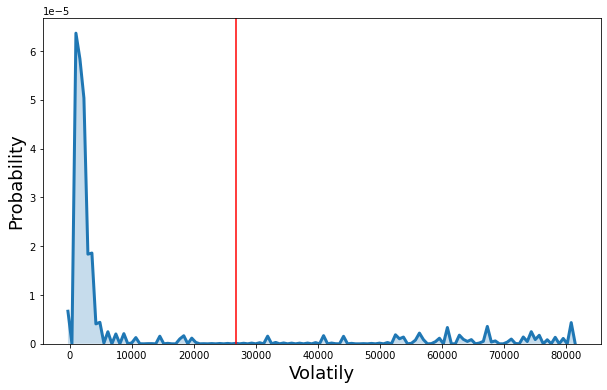

In [45]:
# Probability graph for volatility
pyplot.figure(figsize=(10,6))
sns.distplot(volatilityTrain.signal, hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 3})
pyplot.axvline(x=volatilityForecastMean.iloc[len(volatilityForecastMean)-1],color='red',label='Expected Volatility')
pyplot.ylabel('Probability', fontsize=18)
pyplot.xlabel('Volatily', fontsize=18)